- Limpiar la data de valores nulos
- Ver si podemos aplicar el target encoding (y resumir más la dummies)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as no
import seaborn as sns
import missingno as msno #Para graficar mis nulos
import gc
import warnings

warnings.filterwarnings('ignore') #Para que no me salgan caveats
gc.collect() #Como garbage cleaner
df = pd.read_csv('data_pseudo_limpia2.csv')
pd.set_option('display.max_columns',None) #Para ver todas mis columnas...

In [2]:
#Eliminaré las variables que no tienen data en sí.
df.drop(['EsCondominio'], inplace = True, axis=1)
df.drop(['NoTieneAlgunDatoExtra'],inplace=True,axis=1)
df.drop(['Area_Terreno'],inplace=True,axis=1)

In [3]:
cols = df.columns
print(*cols)

Unnamed: 0 Antiguedad Anunciante Balneario NroBanios Nro_pisos Cocheras Descripcion Direccion Disposicion Dormitorios Estado de Inmueble Fecha_pub Fila Fondo Frente Luminosidad Mantenimiento Mascotas Medidas Pisos_construibles TipoPuertaCochera Precio Referencia Tipo TipoCochera Ubicacion SinNombre Urbaniz Uso_comercial Uso_profesional Area_constr Area_total Area_constr_m2 Area_total_m2 Area_Terreno_m2 match 'Comedor' 'anx81tico' 'Deposito' 'Banio de servicio' 'Banio independiente' 'Patio' 'Sala' 'Banio de visitas' 'Escritorio' 'Balcon' 'Comedor diario' 'Kitchenette' 'Terraza' 'Sotano' 'Jardanxadn Interno' 'Cocina' 'Sala de estar' 'Lavanderanxada' 'Closet' 'Walking Closet' 'Cuarto de servicio' 'Conexion a gas' 'Guardiananxada' 'Luz' 'Sistema de seguridad' 'Agua' 'Internet' 'Servicio de Limpieza' 'Telefono' 'Cable' 'Areade sauna' 'Club House' 'anx81reas verdes' 'Piscina' 'Guarderanxada' 'Parque interno' 'Areade BBQ' 'Gimnasio' 'Solarium' 'Hall de ingreso' 'Areadeportiva' 'Jardanxadn' 'J

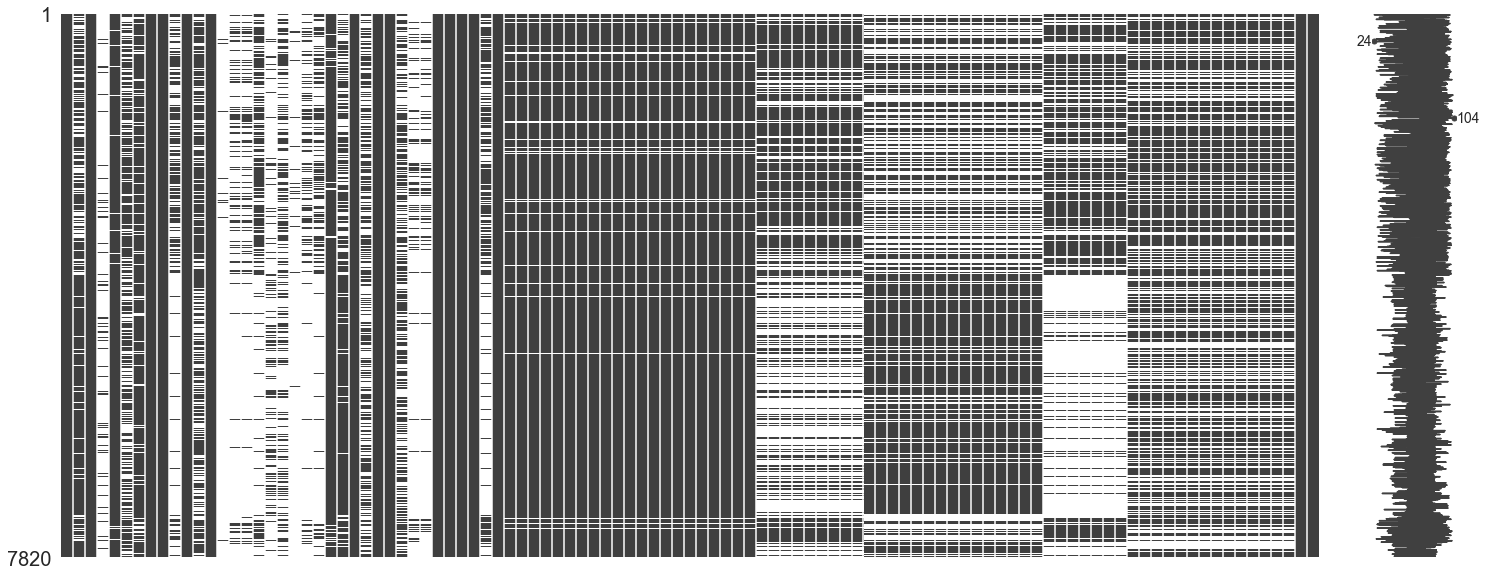

In [4]:
sns.set(style='whitegrid')
msno.matrix(df)

La variable "Balneario" nos dice en qué balneario está nuestra CASA DE PLAYA. Por lo tanto, revisaré si es que todas las casas de Playa tienen esta variable. Sino, reemplazo esos nulos por un "NoEspecifica". Y las casas normales las cambiaré por "NoEsCasaPlaya"  

In [5]:
#Reemplazo los valores nulos de Balneario
df.loc[(df['Balneario'].isna()) & (df['Tipo'] == 'Casa de Playa'),'Balneario'] = 'NoEspecifica'
df.loc[(df['Balneario'].isna()),'Balneario'] = 'Nulo'

Como algunos datos faltantes pueden encontrarse dentro de 'Descripcion', procederemos a standarizar todo descripción y buscar dentro de ella. Para eso, tendremos que reemplazar los valores que no son utf-8 y, a su vez, poner todo en letras minúsculas.

In [6]:
#PODEMOS BUSCAR LA INFO QUE NO ENCONTREMOS DENTRO DE DESCRIPCION
df['Descripcion'] = df['Descripcion'].str.lower() #Convierto todos los strings de la columna en minúsuculas.

In [7]:
o = df[df['Descripcion'].str.contains(' anios')]
o['Antiguedad'].isna() #Como solo hay 94 datos que se pueden reemplazar. Por ahora solo haré el reemplazo dsde la media.

#Reemplazaré Antiguedad por su media.

#OJO, hay casas MAS antiguas que no necesariamente tienen esta edad

##ESta no puede ser la solución más optima, pero opto por hacerla por fines prácticos.
df['Antiguedad'].fillna(int(df.Antiguedad.mean()),inplace=True)

In [8]:
##Nos encargaremos del nro de Banios. LLenaremos con la moda los valores nulos
#sns.countplot(x='NroBanios',data=df)
print(df['NroBanios'].isna().sum())
df['NroBanios'].fillna(5.0,inplace=True)

229


In [9]:
#Hay 3236 nulos en la var Nro_pisos, entonces veremos.
#Tenemos outliers, numero 33 y 44. así como 28... Los explorare,os
df[df['Nro_pisos'] == 33] #Dato erroneo, quiso decir 3 pisos
df[df['Nro_pisos'] == 44] #Dato erroneo, quiso decir 4 pisos
df[df['Nro_pisos'] == 28] #Dato erroneo, quiso decir 2 pisos
dict_r_pisos = {33:3,44:3,28:2}
for word,replace in dict_r_pisos.items():
    df['Nro_pisos'] = df['Nro_pisos'].replace(word,replace)

In [10]:
df[df['Nro_pisos'] == 8] #El de index 4671 sí tiene 8 pisos, mientras que el 6705 tiene 4. 
df.loc[df['Unnamed: 0'] == 7200, 'Nro_pisos'] = 4 #Reemplazo el valor

In [11]:
#Voy a reemplazar Disposición como esquina, buscando dentro de la descripción tal palabra. 
df.loc[(df['Descripcion'].str.contains('esquina')) & (df['Disposicion'].isna()),'Disposicion'] = 'Esquina' #Lista de columnas a reemplazar

###### Antes de continuar reemplazando los valores nulos, quisiera definir bien qué es lo que entiendo por las diferentes variables que hay
###### dentro de este dataset. Específicamente en Area_Terreno_m2, Area_constr_m2 y Area_total_m2.  Su diferencia y posible uso.

Area_Terreno_m2: Sería exactamente el área del terreno que se vende. Puede ser menor que el Area total y el Area Construida.

Area_constr_m2: Es el Area construida, depende del número de pisos que tenga la edificación.

Area_total_m2: Es el area construida mas el area que no se ha contado en la construccion, es decir, si tenemos una casa con
               
               2pisos y 1patio,entonces el Area_total_m2 será la suma del area del patio + area del piso 1 + area del piso2


In [12]:
#Acá estoy asumiendo que las casas con un solo piso, tienen la misma area de terreno y area total. Por lo tanto, reemplazo
#los valores nulos de Area_Terreno_m2 de esa forma. 
df.loc[(df['Nro_pisos'] == 1) & (df['Area_Terreno_m2'].isna()),'Area_Terreno_m2'] = df.loc[(df['Nro_pisos'] == 1) & (df['Area_Terreno_m2'].isna()),'Area_total_m2']

#Asimismo, reemplazaré los que tienen Area_total y Area_terreno igual como si fueran de un piso en los nulos de Nro_pisos


In [13]:
prueba = df[['Area_Terreno_m2','Area_constr_m2','Area_total_m2','Nro_pisos']]
print(prueba.Area_Terreno_m2.isna().sum())
print(prueba.Area_constr_m2.isna().sum())
print(prueba.Area_total_m2.isna().sum())

4546
8
6


#### Se ha optado por reemplazar los valores nulos de nro de pisos buscando dentro de la Descripción cuántos pisos hay

In [14]:
#df.groupby('Anunciante').count().sort_values(['Unnamed: 0','Nro_pisos'],ascending=False) #Para ver qué empresas ponen más nulos

#Primero veremos cuántos casos hay dentro de esta solución (¿Cuántos problemas no solucionaría?)
buscar_pisos = ['pisos','piso','Pisos','niveles','nivel','plantas']
df[((df['Descripcion'].str.contains('|'.join(buscar_pisos))) & (df['Nro_pisos'].isna()))].head()

,Unnamed: 0,Antiguedad,Anunciante,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,SinNombre,Urbaniz,Uso_comercial,Uso_profesional,Area_constr,Area_total,Area_constr_m2,Area_total_m2,Area_Terreno_m2,match,'Comedor','anx81tico','Deposito','Banio de servicio','Banio independiente','Patio','Sala','Banio de visitas','Escritorio','Balcon','Comedor diario','Kitchenette','Terraza','Sotano','Jardanxadn Interno','Cocina','Sala de estar','Lavanderanxada','Closet','Walking Closet','Cuarto de servicio','Conexion a gas','Guardiananxada','Luz','Sistema de seguridad','Agua','Internet','Servicio de Limpieza','Telefono','Cable','Areade sauna','Club House','anx81reas verdes','Piscina','Guarderanxada','Parque interno','Areade BBQ','Gimnasio','Solarium','Hall de ingreso','Areadeportiva','Jardanxadn','Juegos para ninios','Sala de cine','Sala de internet','Cerca al mar','Ingreso independiente','Colegios cercanos','Frente al mar','Centros comerciales cercanos','Parques cercanos','Acceso personas discapacidad','Desagaue','Jacuzzi','Amoblado','Aire acondicionado','Chimenea','Calefaccion','Parrilla','Sauna','Cerco Electrico','Equipado','Portero electrico','Terma','Cocina con reposteros','Intercomunicador',Distrito,Provincia
2,3,2.0,Century 21 Capital,Nulo,4.0,NaN,NaN,venta de amplia casa en estupenda zona de mir...,Av. Diez Canseco Cerca A Parque Tradiciones// ...,Esquina,5+,NaN,Publicado el 24.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,649000.0,A poca caudra de Av. Ricardo Palma,Casa,NaN,Miraflores-Lima,Casa100,NaN,NaN,NaN,215.00 m2,215.00 m2,215.0,215.0,NaN,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Miraflores,Lima
6,7,3.0,No disponible,Nulo,4.0,NaN,NaN,â¡remato! lindo edificio de 03 pisos con pis...,Remato Edificio!! Frente Al Mercado 3 Regiones...,NaN,5+,NaN,Publicado el 01.07.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170000.0,NaN,Casa,NaN,Carabayllo-Lima,Casa1003,NaN,NaN,NaN,500.00 m2,170.00 m2,500.0,170.0,170.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carabayllo,Lima
14,16,3.0,BAQUERIZO CORREA PATRICIA,Nulo,5.0,NaN,NaN,excelente ubicacion! 903 m2. se vende casa en...,"Av. Grau, A Una Cuadra Del Parque Infantil De ...",NaN,5+,NaN,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa,NaN,Piura-Piura,Casa1011,NaN,NaN,NaN,874.14 m2,903.00 m2,874.0,903.0,465.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Piura,Piura
16,19,2.0,Lima Corretaje SAC,Punta Negra,2.0,NaN,NaN,"casa en punta negra, al frente del club soci...",Frente Al Club Social Y Deportes De Punta Negr...,NaN,4,Muy bueno,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,Si,NaN,NaN,NaN,158000.0,Frente al club social y deportes de Punta Negr...,Casa de Playa,NaN,PuntaNegra-Lima,Casa1014,NaN,NaN,NaN,132.00 m2,132.00 m2,132.0,132.0,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PuntaNegra,Lima
22,25,3.0,INMOBILIARIO PERÃ,Nulo,5.0,NaN,2.0,contacto : 9.8.6.9.7.6.1.2.4 venta de casa en...,Calle San Juan Xxx Ma Ve

##### Viendo esto, podemos decir que la data faltante de los pisos puede ser encontrada dentro de 'Descripcion'. Entonces, haremos una funcion para sacarla de ahí

In [15]:
#Voy a buscar dentro de 'Descripcion' si está escondido el número de pisos...
buscar_pisos = ['pisos','piso','Pisos','niveles','nivel','plantas']
dict_pisos = {}
def get_me_the_floor_of_nan(sub, df):
    global dict_pisos
    df_ = df[df['Nro_pisos'].isna()]
    for index,strings in df_['Descripcion'].items():
        position = strings.find(sub)
        if position != -1:
            dict_pisos[index] = strings[position-2]
        else:
            pass
for subs in buscar_pisos:
    get_me_the_floor_of_nan(subs,df)

In [16]:
#Filtramos todos los caracteres que no son dígitos dentro del dataframe.
dict_replace_1 = {}
for key,value in dict_pisos.items():
    if value.isdigit():
        dict_replace_1[key] = value
    else:
        pass

In [17]:
#Pasaremos este dict obtenido a un dataframe, para mejor visualización
df_rep = pd.DataFrame(dict_replace_1, index = [1] )
df_rep = df_rep.transpose()
df_rep.columns = ['Nro_pisos_']
df_rep['Nro_pisos_'].unique()
#................................................NOTA.......................................................
#No existe certeza de que en la descripción se pongan los pisos exactos, sino que a partir de 4 pisos se pongan en sí los 
#parámetros. Entonces, sacaré las casas con parámetros para pisos extras...

array(['3', '0', '4', '8', '2', '7', '5', '1', '6'], dtype=object)

#### Revisando la data se encuentra que a partir de 4 pisos no es certero encontrar la cantidad exacta de pisos dentro de Descripción. Puesto que la gente pone cómo "4 pisos hábiles para construir". Entonces solo nos quedaremos con los menores a 4

In [18]:
df_remp = df_rep[df_rep['Nro_pisos_'] < '4']
df_remp = df_remp[df_remp['Nro_pisos_'] != '0']
#Ahora tengo el dataframe de reemplazo filtrado: df_remp 

In [19]:
#Reemplazo los valores dentro del dataframe original:
df.loc[df_remp.index,'Nro_pisos'] = df_remp['Nro_pisos_']
#Ahora que ya lo tengo reemplazado, veo los números nulos de mi data después.
df['Nro_pisos'].isna().sum()

2876

#### Aún quedan 2876 valores por completar. Haremos un modelo con los valores que no son nulos. Pero primero,
#### Cómo se comportan los nulos en mi dataset?

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

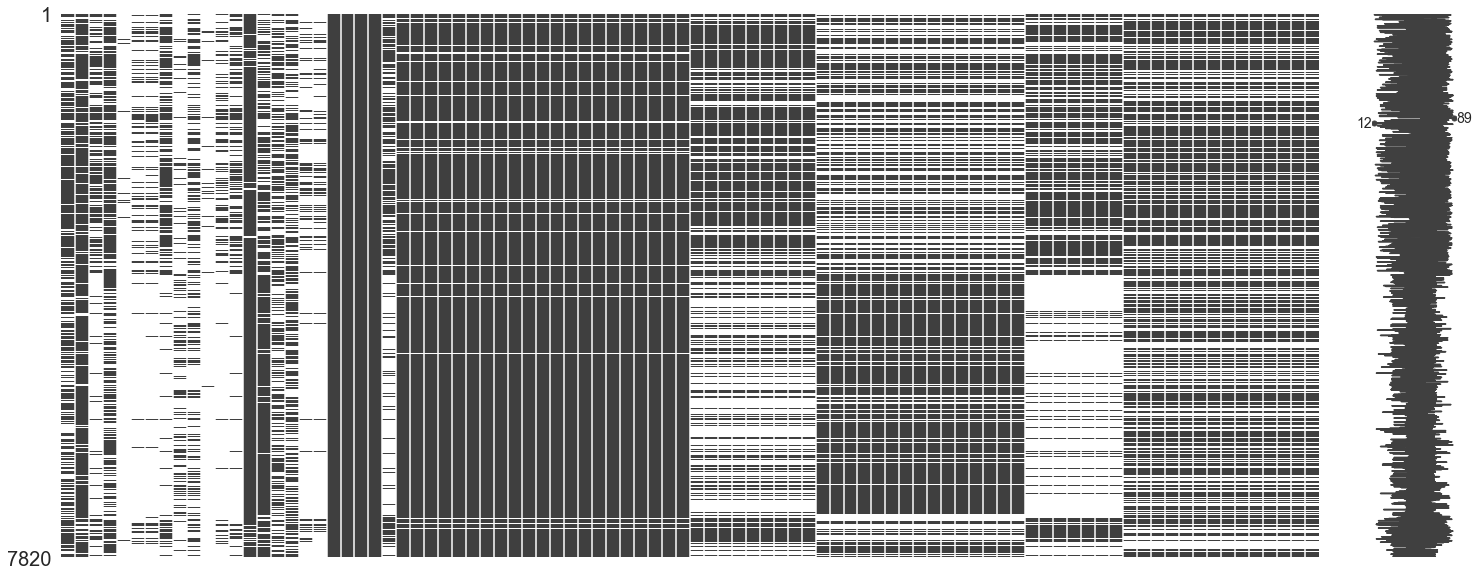

In [20]:
missingcols = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missingcols])

In [21]:
drop_to_predict = df.loc[(df['\'Balcon\''] == 1) & (df['Nro_pisos']==1) & (df['Tipo'] == 'Casa')].index
#Se supone que debería ser nulo dado que ninguna casa con balcón debería tener un piso
drop_to_p2 = df.loc[(df['\'Balcon\''] == 1) & (df['Nro_pisos']==1) & (df['Anunciante'] == 'OPB GRUPO INMOBILIARIO ')].index
indx_to_drop = list(drop_to_predict) + list(drop_to_p2)
df.drop(indx_to_drop,axis=0, inplace=True)

#### Haremos un modelo para completar los nulos de Nro_pisos, para eso tendremos que ver las variables predictoras.

In [22]:
#En este modelo no vy a contar los pisos que sean mayores a 5, dada que la prob de que sea mayores a 5 y no estén registrados es poca
df['Nro_pisos'] = df['Nro_pisos'].apply(pd.to_numeric, errors='coerce')
to_drop_ = df[df['Nro_pisos']>6].index

In [23]:
x_cols = ['NroBanios','Dormitorios','Area_constr_m2','Area_total_m2','\'anx81tico\'','Tipo','Precio']
Y = df['Nro_pisos'].dropna() #Acá tendré mis target para train y test
index_train = Y.index 
X = df[x_cols] 
X = X.loc[index_train] #Acá tendré mis X para eñ train y test
X.drop(to_drop_,axis=0,inplace=True) #dropeo como quedamos arriba

In [24]:
X['\'anx81tico\''].fillna(0,inplace=True)
X.dropna(axis=0,inplace=True)

In [25]:
index_drop = X[X.Precio < 20000].index #Estos precios no son lógicos!!!
X.drop(index_drop,axis=0,inplace=True)

In [26]:
x_index = X.index
Y = Y.loc[x_index] #No necesito dropear las dos columnas, sino solo filtrar en la Y

Agregamos esta variable pq creemos que puede ayudar al algoritmo

In [27]:
X['Dif_areas'] = X['Area_total_m2'] - X['Area_constr_m2']

#### Ahora, transformaremos las variables para el modelo

https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [29]:
#Usaremos LabelEncoder para Dormitorios y OneHot para distritos. Sí, es más fácil aplicar a mano el reemplazo para dormitorios,
#Pero en este caso, veremos cómo lo hace LabelEncoder.

LabelEncoder = LabelEncoder()
X['Dormitorios'] = LabelEncoder.fit_transform(X['Dormitorios'])

#### En este caso normalizaremos la data, de tal forma que podamos trabajar mejor con el modelo de ML

In [30]:
from sklearn.preprocessing import normalize

In [31]:
X_to_norm = [X['Precio'],X['Area_constr_m2'],X['Area_total_m2'],X['Dif_areas']]
X_to_norm = normalize(X_to_norm)
#Hasta acá hemos normalizado las columnas

X = X.assign(Precio = X_to_norm[0])
X = X.assign(Area_constr_m2 = X_to_norm[1])
X = X.assign(Area_total_m2 = X_to_norm[2])
X = X.assign(Dif_areas = X_to_norm[3])
#Agregamos al normalización a la data que vamos a entrenar y vemos cómo ha cambiado...
X.head(3)

,NroBanios,Dormitorios,Area_constr_m2,Area_total_m2,'anx81tico',Tipo,Precio,Dif_areas
0,5.0,4,0.012140,0.005462,0.0,Casa,0.004682,0.0
1,3.0,4,0.006192,0.002786,0.0,Casa,0.002148,0.0
2,4.0,4,0.007479,0.003365,0.0,Casa,0.008937,0.0


In [32]:
ohe = pd.get_dummies(X['Tipo'])
X_ = pd.concat([X,ohe],axis=1)

In [33]:
X_.drop('Tipo',axis=1,inplace=True)

In [34]:
#Dividiremos la data en train y test.
X_train, X_test, y_train, y_test = train_test_split(X_, Y, random_state = 41)

###### Después de probar algunos modelos, nos quedamos con un árbol de decisión para predecir finalmente.

In [35]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.metrics import accuracy_score

In [36]:
#Finding our optimize max_depth
for i in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=i)
    tree_clf.fit(X_train,y_train)
    y_pred = tree_clf.predict(X_test)
    print("Test accuracy of the Decision Trees model:", accuracy_score(y_pred,y_test), "for max_depth: ", i)

Test accuracy of the Decision Trees model: 0.5767284991568297 for max_depth:  1
Test accuracy of the Decision Trees model: 0.6011804384485666 for max_depth:  2
Test accuracy of the Decision Trees model: 0.6003372681281619 for max_depth:  3
Test accuracy of the Decision Trees model: 0.606239460370995 for max_depth:  4
Test accuracy of the Decision Trees model: 0.6045531197301856 for max_depth:  5
Test accuracy of the Decision Trees model: 0.6138279932546374 for max_depth:  6
Test accuracy of the Decision Trees model: 0.6146711635750421 for max_depth:  7
Test accuracy of the Decision Trees model: 0.6290050590219224 for max_depth:  8
Test accuracy of the Decision Trees model: 0.627318718381113 for max_depth:  9
Test accuracy of the Decision Trees model: 0.6180438448566611 for max_depth:  10
Test accuracy of the Decision Trees model: 0.6003372681281619 for max_depth:  11
Test accuracy of the Decision Trees model: 0.5885328836424958 for max_depth:  12
Test accuracy of the Decision Trees mod

In [37]:
#Basic Decision Tree model
tree_clf = DecisionTreeClassifier(max_depth = 8)
tree_clf.fit(X_train,y_train) #training the model

#Predicting with the model
y_pred = tree_clf.predict(X_test)

#We will try to evaluate the accuracy score
print("Test accuracy of the Decision Trees model:", accuracy_score(y_pred,y_test))

Test accuracy of the Decision Trees model: 0.6298482293423272


#### Ahora que ya tenemos nuestro modelo seleccionado, vamos a hacer la predicción.
Para eso tendremos que predecir la data nula, entonces extraemos:

In [38]:
df_p = df[df['Nro_pisos'].isna()]
X_predict = df_p[x_cols]
X_predict['\'anx81tico\''].fillna(0,inplace=True)
X_predict.dropna(axis=0,inplace=True)
#index_drop = X_predict[X_predict.Precio<20000] ###LUEGO CAMBIAR Y CORREGIR _<<<<<<<<----------------------------------------
#X_predict.drop(index_drop,axis=0,inplace=True)
X_predict['Dif_areas'] = X_predict['Area_total_m2'] - X_predict['Area_constr_m2']
X_predict['Dormitorios'] = LabelEncoder.fit_transform(X_predict['Dormitorios'])
X_predict_to_norm = [X_predict['Precio'],X_predict['Area_constr_m2'],X_predict['Area_total_m2'],X_predict['Dif_areas']]
X_predict_to_norm = normalize(X_predict_to_norm)
#Hasta acá hemos normalizado las columnas

X_predict = X_predict.assign(Precio = X_predict_to_norm[0])
X_predict = X_predict.assign(Area_constr_m2 = X_predict_to_norm[1])
X_predict = X_predict.assign(Area_total_m2 = X_predict_to_norm[2])
X_predict = X_predict.assign(Dif_areas = X_predict_to_norm[3])

dummy = pd.get_dummies(X_predict['Tipo'])
X_predict_ = pd.concat([X_predict,dummy], axis=1)

X_predict_.drop('Tipo',axis=1,inplace=True)

#Ahora ya tengo mi X_predict_ final, para poder predecir lo que quisiera
X_predict_.head()

,NroBanios,Dormitorios,Area_constr_m2,Area_total_m2,'anx81tico',Precio,Dif_areas,Casa,Casa de Playa,Casa de Playa en condominio,Casa de campo,Casa en condominio,Casa en quinta
16,2.0,3,0.005607,0.001974,0.0,0.002142,0.000000,0,1,0,0,0,0
22,5.0,4,0.009047,0.003650,1.0,0.004339,0.000578,1,0,0,0,0,0
28,5.0,4,0.025485,0.008975,0.0,0.007458,0.000000,0,1,0,0,0,0
29,4.0,3,0.014442,0.077513,0.0,0.014915,0.090255,0,0,0,1,0,0
31,3.0,4,0.008028,0.004263,0.0,0.007458,0.001789,1,0,0,0,0,0


Ahora, haremos la predicción de los datos entrenando con toda la data total y labelizada que tenemos...

In [39]:
tree_clf.fit(X_,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
Y_predict = tree_clf.predict(X_predict_)

In [41]:
Y_predict

array([2., 2., 3., ..., 2., 2., 1.])

In [42]:
X_predict_.index

Int64Index([  16,   22,   28,   29,   31,   53,   58,   59,   60,   62,
            ...
            7775, 7779, 7788, 7789, 7803, 7807, 7813, 7814, 7817, 7819],
           dtype='int64', length=2808)

In [43]:
#Acá tengo la data agregada, lista para poder reemplazar a los valores que quiera...
df_pred_pisos = pd.DataFrame(Y_predict)
df_pred_pisos.index = X_predict_.index
df_pred_pisos.columns = ['Nro_pisos']

Ahora, uniré la data con la data original que tenía y por index...

In [44]:
#Ahora hemos unido el dataframe finalmente y nuestra cantidad de nulos ha disminuido!!!
df.loc[X_predict_.index,'Nro_pisos'] = Y_predict

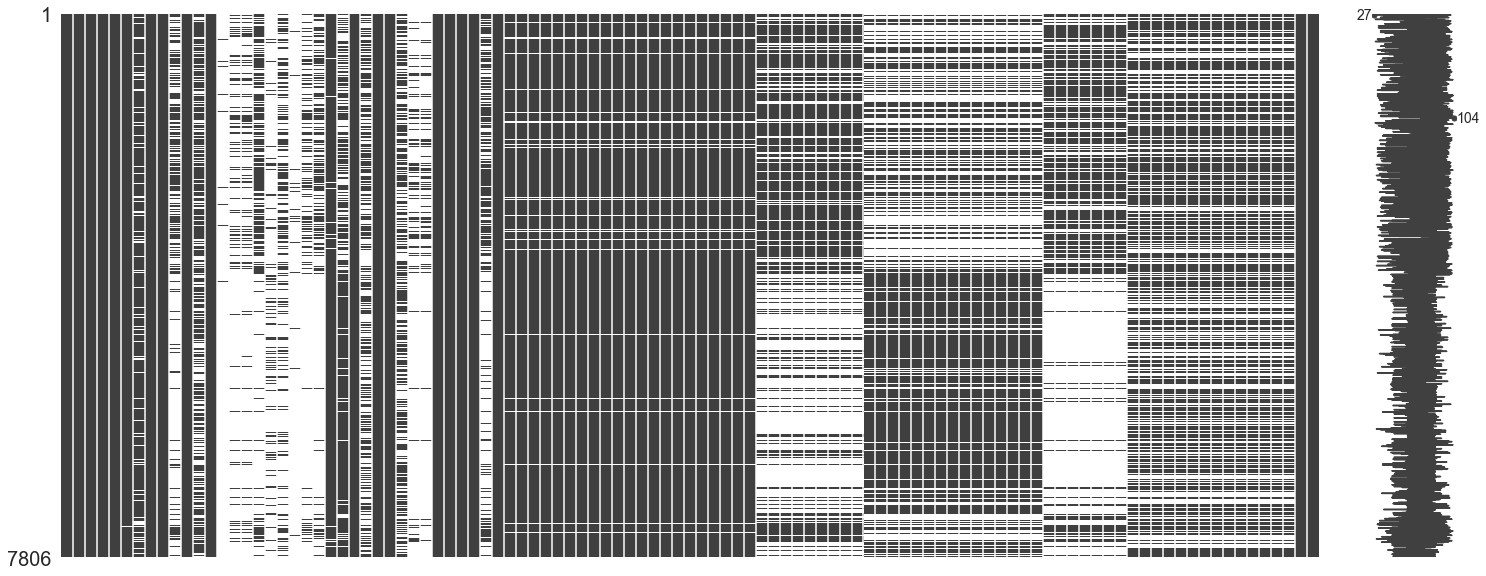

In [45]:
msno.matrix(df)

In [53]:
#Eliminar el Nro de pisos nulos.
drop_ = df[df['Nro_pisos'].isna() == True].index
df.drop(drop_, inplace=True)

In [80]:
df[((df['Descripcion'].str.contains('cochera')) & (df['Cocheras'].isna()))]

dict_cocheras = {}
df_ = df[df['Cocheras'].isna()]
for index,strings in df_['Descripcion'].items():
    position = strings.find('cocheras')
    if position != -1:
        dict_cocheras[index] = strings[position-2]
    else:
         pass
        
dict_replace_2 = {}
for key,value in dict_cocheras.items():
    if value.isdigit():
        dict_replace_2[key] = value
    else:
        pass

#Pasaremos este dict obtenido a un dataframe, para mejor visualización
df_rep = pd.DataFrame(dict_replace_2, index = [1] )
df_rep = df_rep.transpose()
df_rep.columns = ['Cocheras']

#Reemplazo los valores dentro del dataframe original:
df.loc[df_rep.index,'Cocheras'] = df_rep['Cocheras']

In [83]:
df['Cocheras'].fillna(0, inplace=True)

Por cuestiones prácticas...

In [91]:
df.drop('Disposicion',axis=1,inplace=True)

In [97]:
df['Estado de Inmueble'].fillna('NoEspecifica', inplace=True)

In [101]:
df.drop('Fila',axis=1,inplace=True)

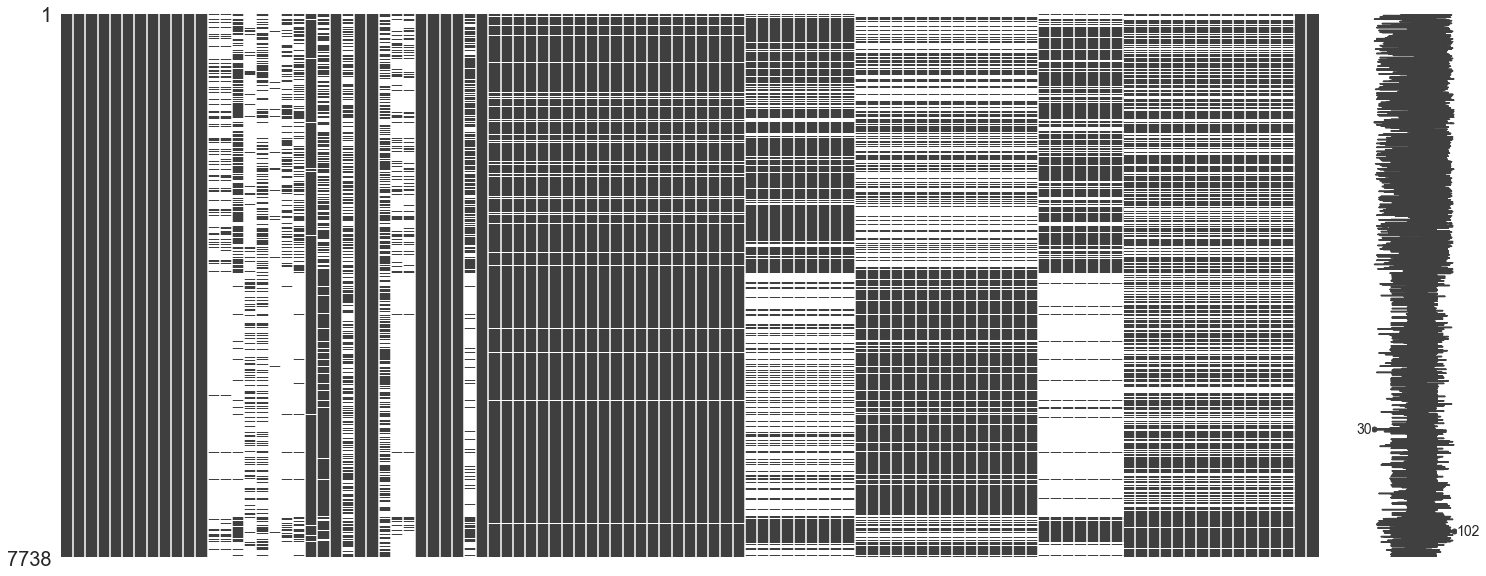

In [102]:
msno.matrix(df)

In [105]:
df.Fondo.isna().sum() #...

6597